In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
p = RollRig.base_params(3)

In [51]:
sm = mf.SymbolicModel.from_file('RollRigModel.py')
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[2]))})

In [57]:
p.c.value = 0.067
p.s.value = 1
p.sigma.value = 0.28
p.m_w.value = 0.22
p.m_f.value = 0.038
p.m_l.value = 0#0.0275
p.alpha_r.value = 0
p.c_d_max.value = 1
p.a_0.value = 2*np.pi
#p.tau.value = 0
p.alpha_r.value = 0
p.w_g.value = 0
p.beta.value = 0

#p.s.value = 0.72
#p.sigma.value = 0
#p.m_f.value = 0
#p.m_l.value = 0


p.Lambda.value = np.deg2rad(10)
p.sigma.value
p.rho.value

In [58]:
nm = mf.NumericModel.from_SymbolicModel(p,sm)

ext_f = nm.ExtForces.force_funcs[0]

In [59]:
thetadot = sym.Symbol('thetadot')
steadyState = sm.msubs({p.qd[1]:0,p.qd[2]:0,p.qd[0]:thetadot,p.w_g:0})

eom = steadyState.ExtForces.Q()-steadyState.f+sym.Matrix([p.V**2*p.beta,0,0])


eom_func = sym.lambdify((p.GetTuple(),thetadot,p.q),eom)
q = np.deg2rad([0,10,10])
d_theta = np.deg2rad(100)
x = eom_func(p.GetNumericTuple([q[0],d_theta,q[1],0,q[2],0],0),d_theta,q)[:,0]
#(sm.subs({p.qd[1]:0,p.qd[2]:0}).ExtForces.Q()[0])


array([-0.82968611,  0.03097877, -0.05760049])

In [60]:
p.beta.value = 0.0037
p.V.value = 22.5
p.alpha_c.value = np.deg2rad(0)

#res = fsolve(lambda x,v:eom_func(p.GetNumericTuple([v,x[0],x[1],0,x[2],0],0),x[0],[v,x[1],x[2]])[:,0],np.deg2rad([0,0,0]),args = (0,)) 
res = fsolve(lambda x,v:eom_func(p.GetNumericTuple([v,x[0],0,0,0,0],0),x[0],[v,0,0])[0,0],np.deg2rad([0]),args = (0,)) 


list(np.round(np.rad2deg(res),2))

In [72]:

model = nm
ext_f = model.ExtForces.force_funcs[0]

end_time = 10

constraints = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
#constraints = [np.NaN,np.NaN,0,0,0,0]

def objectiveDeriv(t,y):
    deriv = list(model.deriv(t,y,p.GetNumericTuple(y,t)))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

torque_period = 0.1
torque_max = 0.0037*p.V.value**2

def torque(tup,x,t):
    if t<2:
        return 0
    elif t<torque_period/2+2:
        return torque_max*0.5*(1- np.cos(2*np.pi*(t-2)/torque_period))
    else:
        return torque_max
    
    
def custom_force(tup,x,t):
    return np.array([[torque(tup,x,t)],[0],[0]])

#angle_period = 0.1
#angle_max = np.deg2rad(0)
#def Angle(t,x):
#    res = np.array([[0],[0],[0]])   
#    if t<2:
#        return 0
#    elif t<angle_period/2+2:
#        return angle_max*0.5*(1- np.cos(2*np.pi*(t-2)/angle_period))
#    else:
#        return angle_max
#p.beta.value = Angle
    
    
#p.tau.value = torque
model.ExtForces.force_funcs = [ext_f , custom_force]

# Generate I.C. and run the solver
x = [0]*p.qs*2
#x[::2] = fp_dict['q']
yData = solve_ivp(objectiveDeriv,(0,end_time),x,max_step=0.01)

#interpolate to reduce t and y points
int_func = interp1d(yData.t,yData.y)

t = np.linspace(0,end_time,(end_time*100)+1)
yi = int_func(t)
y = yi[:,-1]
list(model.deriv(10,y,p.GetNumericTuple(y,10)))

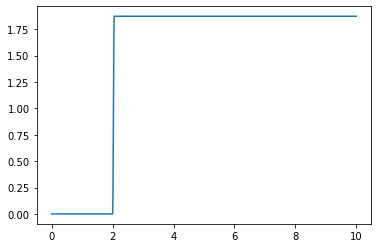

In [73]:
plt.plot(t,[torque((0,),[0],i) for i in t])

486.85605652647445


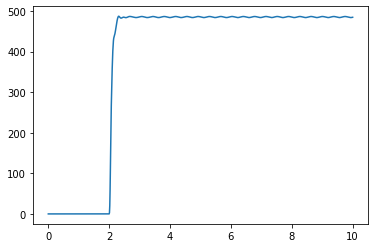

In [74]:
plt.plot(t,np.rad2deg(yi[1,:]))
print(max(np.rad2deg(yi[1,:])))

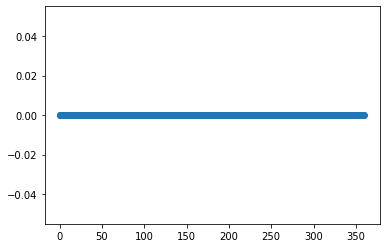

In [71]:
ind = t>4
plt.plot(np.mod(np.rad2deg(yi[0,ind]),360),np.rad2deg(yi[2,ind]),'o')

In [16]:
sm_mini = sm.subs({p.sigma.name:0,p.sigma:0,p.m_f.name:0,p.m_l.name:0})
eom = (sm_mini.M.inv()*(-sm_mini.f+sm_mini.ExtForces.Q()))[0]+sym.Symbol('gamma')*sym.Rational(1,2)*1.225*p.V**2*0.067*0.12*2*sym.pi

eom = sym.simplify(eom.subs({p.c.name:0.067,p.sigma:0,p.sigma.name:0,p.m_w:p.s*0.305}))#,p.beta.name:0,p.rho.name:1.225,p.c:0.067,p.sigma:0,p.a_0.name:2*sym.pi,p.rho:1.225,p.m_w:p.s*0.305})
#eom = sym.simplify(eom).expand()
eom.args[0]/-eom.args[1]*p.qd[0]
eom

In [43]:
eom = sym.simplify((sm_mini.M.inv()*(-sm.f+sm.ExtForces.Q()))[0].subs({p.sigma.name:0,'c':0.067,'rho':1.225, p.a_0.name:2*sym.pi,p.beta.name:0}).subs({p.sigma:0}))+sym.Symbol('gamma')*sym.Rational(1,2)*1.225*p.V**2*0.067*0.12*2*sym.pi
eom#.args[0]/-eom.args[1]*p.qd[0]
sm_mini.M.inv()

⎡  12  ⎤
⎢──────⎥
⎢     2⎥
⎣m_w⋅s ⎦

In [18]:
ff.subs({'sigma':0})

In [85]:
type(val)

ModelFramework.ModelParameters.ModelSymbol

In [22]:
sm.ExtForces.Q().subs({p.sigma.name:0}).subs({p.sigma:0})

⎡                        ⎛   2                        ⎞        ⎛ 2            
⎢                      2 ⎜  V ⋅a₀⋅β⋅c⋅ρ   V⋅a₀⋅c⋅ρ⋅w_g⎟      2 ⎜V ⋅a₀⋅β⋅c⋅ρ   
⎢            3      5⋅s ⋅⎜- ─────────── + ────────────⎟   5⋅s ⋅⎜─────────── + 
⎢  V⋅a₀⋅c⋅ρ⋅s ⋅q₀̇        ⎝       4             4      ⎠        ⎝     4       
⎢- ────────────── - ─────────────────────────────────── + ────────────────────
⎣        24                          36                                   36  

            ⎞⎤
V⋅a₀⋅c⋅ρ⋅w_g⎟⎥
────────────⎟⎥
      4      ⎠⎥
─────────────⎥
             ⎦